In [1]:
%run ./load_src_module.py

In [2]:
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

In [3]:
from src.datasets import PersonalityCaptions, DatasetManager
from src.models import Encoder, Discriminator, EncoderGeneratorAttention, Generator
from src.train import MonteCarloRollout
from src.utils import MultiCheckpointManager
from src.schedules import ExponentialSchedule
from src.preprocess import Tokenizer
from src.evaluate import score_on_test_set, _seq_to_text
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
pc = PersonalityCaptions("/Users/akshaykurmi/NEU/AML-CS7140/aml-project/personality_captions_data")

In [5]:
dm = DatasetManager(pc, 20)

In [209]:
encoder = Encoder()
generator = Generator(token_vocab_size=dm.tokenizer.vocab_size,
                      style_vocab_size=dm.style_encoder.num_classes,
                      style_embedding_units=64,
                      token_embedding_units=512,
                      lstm_units=512,
                      lstm_dropout=0.5,
                      attention_units=512,
                      encoder_units=2048,
                      z_units=256, stylize=True)
# checkpoint_manager = MultiCheckpointManager("/Users/akshaykurmi/NEU/AML-CS7140/aml-project/results/run_2001/checkpoints", {
#     "generator": {"generator": generator}
# })
# checkpoint_manager.restore({"generator": 3739})
checkpoint_manager = MultiCheckpointManager("/Users/akshaykurmi/NEU/AML-CS7140/aml-project/results/run_2003/checkpoints", {
    "generator": {"generator": generator}
})
checkpoint_manager.restore({"generator": 3950})

In [232]:
dm.style_encoder.num_classes

217

In [7]:
ds = pc.load("test")

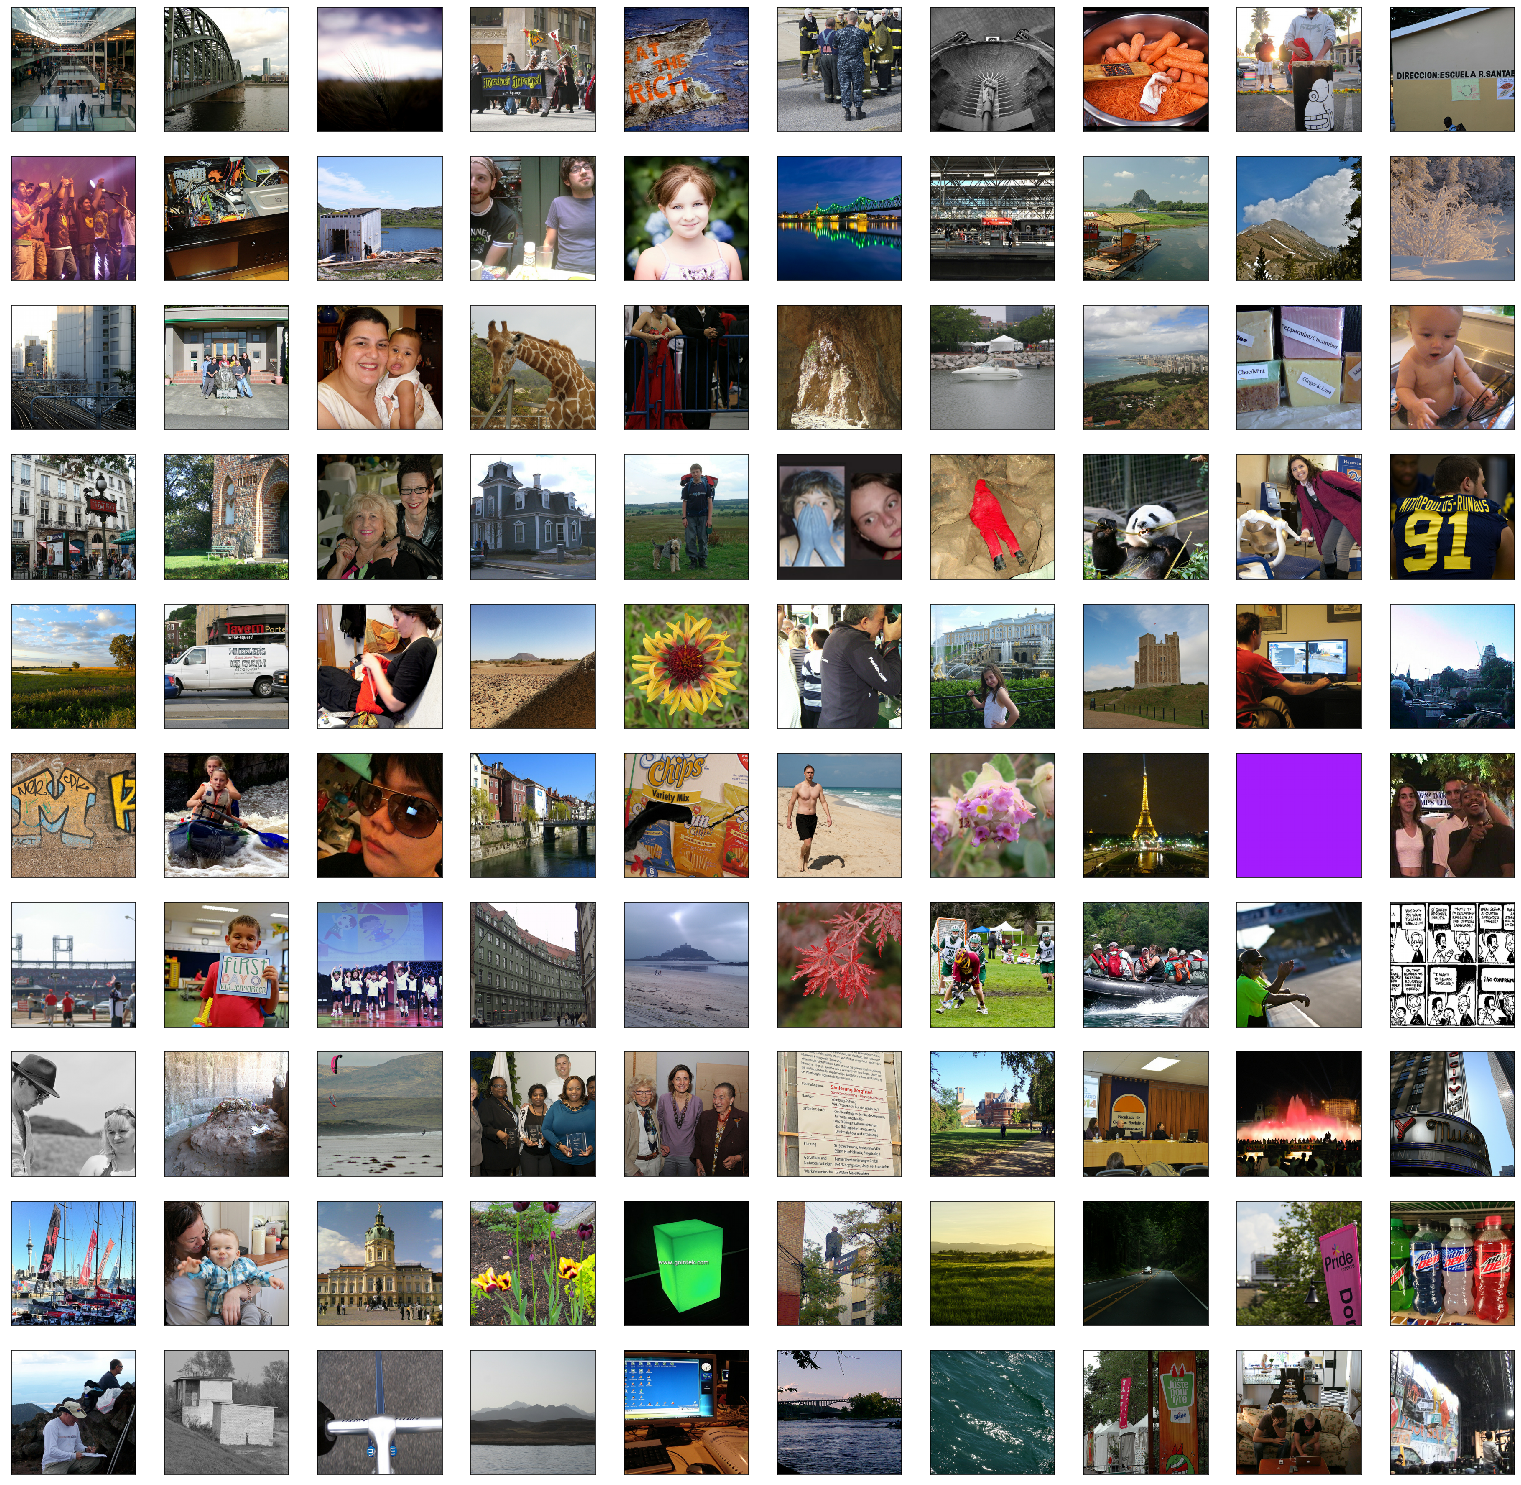

In [71]:
fig=plt.figure(figsize=(27,27))
columns, rows = 10, 10
for i in range(columns * rows):
    img = dm.load_image(ds[i+1500]["image_path"]).numpy().astype(np.int32)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

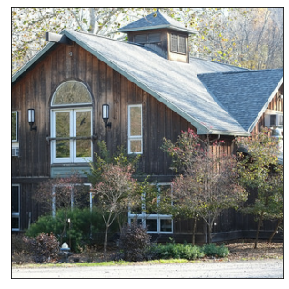

In [245]:
i = 2809
image_path = ds[i]["image_path"]
image = dm.load_image(image_path)
plt.figure(figsize=(5,5))
plt.imshow(image.numpy().astype(np.int32))
plt.xticks([])
plt.yticks([])
plt.show()

In [246]:
ds[i]

{'style': 'Empathetic',
 'caption': 'I feel sorry for who ever has to clean those gutters.',
 'additional_captions': ['It is the nice place to live. It share my feeling of calmness.',
  'this building is looking kind of old. I would rebuild it for the owners free of charge',
  'I will find someone to spruce up the house',
  'I feel sorry for anyone that does not live here'],
 'image_path': '/Users/akshaykurmi/NEU/AML-CS7140/aml-project/personality_captions_data/images/aa83919eef8b663e875c969672c476b0.jpg'}

In [ ]:
encoder_output = encoder(tf.expand_dims(image, axis=0))
for s in range(dm.style_encoder.num_classes):
    style_label = dm.style_encoder.index_to_label[s]
    print(f"\033[1m===== {s} : {style_label} =====\033[0m")
    style = tf.constant(s, dtype=tf.int32, shape=(1,))
    sequences, sequences_logits = generator.beam_search(encoder_output, style, sequence_length=20,
                                                        beam_size=5, sos=dm.tokenizer.start_id,
                                                        eos=dm.tokenizer.end_id)
    for seq, logit in zip(sequences.numpy()[0], sequences_logits.numpy()[0]):
        print(f"{logit:0.5f} | {_seq_to_text(dm, seq)}")

    initial_sequence = tf.ones((1, 1), dtype=tf.int64) * dm.tokenizer.start_id
    sequences = generator.sample(encoder_output, initial_sequence, style,
                                 sequence_length=20, mode="stochastic", n_samples=5,
                                 training=False, sos=dm.tokenizer.start_id,
                                 eos=dm.tokenizer.end_id)[0]
    for seq in sequences:
        print(f"{_seq_to_text(dm, seq.numpy()[0])}")
    print()